# Downsampling the enormous data set
Lacking access to a cluster, I will downsample the data so that it fits into RAM. The analysis code that follows in other notebooks, especially where Spark is used, should work identically regardless of downsampling though.

End result of sampling: raw data $\rightarrow$ `event_ds.csv`, ~12 GB $\rightarrow$ 0.3GB. 

## Obtain unique user_ids and extract subset

Count and identify unique user ids, using a shell script. We only care about those users who have actually played a song, instead of just downloading or searching. 

Assumes that we have already run `2_unpack_and_clean_files.sh`.

In [2]:
import numpy as np
import pandas as pd
import csv

In [2]:
import os

cmd="""
export LC_CTYPE=C 
export LANG=C
# get uid field| sort | count unique ids | strip blank spaces | output to file
cat ../data/play/all_play_log| cut -f1 -d$'\t'| sort | uniq -c | sed -e 's/^ *//g;s/ *$//g'> ../data/uid_count.csv
"""
os.system(cmd)

In [7]:
# Load CSV file recording unique, valid user ids
df = pd.read_csv('../data/uid_count.csv',sep='\s+', names=['count','uid'])

# Inspect the DataFrame; confirmed no missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594735 entries, 0 to 594734
Data columns (total 2 columns):
count    594735 non-null int64
uid      594734 non-null float64
dtypes: float64(1), int64(1)
memory usage: 9.1 MB


In [8]:
# Further inspection: all uids are non-negative, min = 0 (good!)
df.describe()

,count,uid
count,5.947350e+05,5.947340e+05
mean,2.460525e+02,1.673628e+08
std,1.526662e+04,1.047142e+07
min,1.000000e+00,0.000000e+00
25%,9.000000e+00,1.680262e+08
50%,4.000000e+01,1.684782e+08
75%,1.740000e+02,1.687685e+08
max,7.501794e+06,1.692623e+08


## Remove bots and outliers
Bot records can come from stress tests of systems, where artifically many play events were generated and recorded in logs. Bot events have to be removed, before we can study churning / make  recommendations based on the behavior of *real* users.

In [9]:
# The magical plotting library
import matplotlib.pyplot as plt

# Beautify plots; display plots automatically without plt.show() or similar
plt.style.use("ggplot")
%matplotlib inline

Text(0.5, 1.0, 'Distribution of Plays Per User')

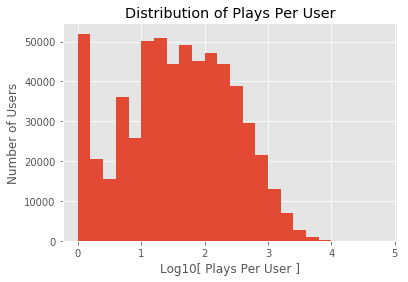

In [10]:
# Most users have less than 10^3 plays in the data set's time frame
np.log10(df['count']).plot.hist(bins=np.arange(0,5,0.2))
plt.xlabel("Log10[ Plays Per User ]")
plt.ylabel("Number of Users")
plt.title("Distribution of Plays Per User")

In [11]:
# Manually explored the percentile of counts. Settled on 99.
# 43 days of data. 2091 / 43 = ~49 play events per day. Still within reason.
top_count_threshold = np.percentile(df['count'], 99)
print(top_count_threshold)

2091.0


In [12]:
print("total number of users:", len(df['uid']))

total number of users: 594735


In [13]:
# remove bots: get id with play counts<top_count_threshold
id_list_bot_removed = df['uid'][ df['count']<top_count_threshold ].dropna()
id_list_bot_removed = id_list_bot_removed.values

In [14]:
print("total number of users after bots are removed:",len(id_list_bot_removed))

total number of users after bots are removed: 588784


## Downsample on `uid` level

In [15]:
# Compute the set of user_ids to keep
# Convert to Python set object, for easy searching

np.random.seed = 1
down_sample_ratio = 0.11
id_subset = set(id_list_bot_removed[np.random.random(id_list_bot_removed.shape) < down_sample_ratio])

In [16]:
print("total number of users after down sample:", len(id_subset))

total number of users after down sample: 64746


In [17]:
# Define str->date type conversion function

import datetime
def convert_date(s):
    s = str(s).strip()
    try:
        year = int(s[:4])
        month = int(s[4:6])
        day = int(s[6:8])
        return datetime.date(year,month,day)
    except:
        return None

In [18]:
### Downsampling --- for play events

# Define input and output file names; also, the CSV fields to read and write out to
input_file = '../data/play/all_play_log'
output_file = '../data/play_ds.csv'
input_field_list = ['uid','device','song_id','song_type','song_name','singer','play_time','song_length','paid_flag','date']
output_field_list = ['uid','device','song_id','date','play_time','song_length']

i=0 # Keep track of the number of rows processed


with open(input_file,'r',encoding='latin-1') as fin, open(output_file,'w') as fout:
    csvin = csv.DictReader(fin,delimiter='\t',fieldnames=input_field_list,quoting=csv.QUOTE_NONE)
    csvout = csv.writer(fout,delimiter=',')
    csvout.writerow(output_field_list) # write header
    for row in csvin:
        i+=1
        if i%1000000==0:
            print("#row processed:",i)
        try:
            int(row['uid'])
        except:
            continue
        if int(row['uid']) in id_subset:
            row['date'] = convert_date(row['date'])
            if row['date'] != None: 
                csvout.writerow([str(row[key]).strip() for key in output_field_list])

#row processed: 1000000
#row processed: 2000000
#row processed: 3000000
#row processed: 4000000
#row processed: 5000000
#row processed: 6000000
#row processed: 7000000
#row processed: 8000000
#row processed: 9000000
#row processed: 10000000
#row processed: 11000000
#row processed: 12000000
#row processed: 13000000
#row processed: 14000000
#row processed: 15000000
#row processed: 16000000
#row processed: 17000000
#row processed: 18000000
#row processed: 19000000
#row processed: 20000000
#row processed: 21000000
#row processed: 22000000
#row processed: 23000000
#row processed: 24000000
#row processed: 25000000
#row processed: 26000000
#row processed: 27000000
#row processed: 28000000
#row processed: 29000000
#row processed: 30000000
#row processed: 31000000
#row processed: 32000000
#row processed: 33000000
#row processed: 34000000
#row processed: 35000000
#row processed: 36000000
#row processed: 37000000
#row processed: 38000000
#row processed: 39000000
#row processed: 40000000
#row proc

In [19]:
### Downsampling --- for download events

import csv
input_file = '../data/down/all_down_log'
output_file = '../data/down_ds.csv'
input_field_list = ['uid','device','song_id','song_name','singer','paid_flag','date']
output_field_list = ['uid','device','song_id','date']
i=0
with open(input_file,'r',encoding='latin-1') as fin, open(output_file,'w') as fout:
    csvin = csv.DictReader(fin,delimiter='\t',fieldnames=input_field_list,quoting=csv.QUOTE_NONE)
    csvout = csv.writer(fout,delimiter=',')
    csvout.writerow(output_field_list) # write header
    for row in csvin:
        i+=1
        if i%1000000==0:
            print("#row processed:",i)
        try:
            int(row['uid'])
        except:
            continue
        if int(row['uid']) in id_subset:
            row['date'] = convert_date(row['date'])
            if row['date'] != None: 
                csvout.writerow([str(row[key]).strip() for key in output_field_list])


#row processed: 1000000
#row processed: 2000000
#row processed: 3000000
#row processed: 4000000
#row processed: 5000000
#row processed: 6000000
#row processed: 7000000


In [20]:
### Downsampling --- for search events  

import csv
input_file = '../data/search/all_search_log'
output_file = '../data/search_ds.csv'
input_field_list = ['uid','device','time_stamp','search_query','date']
output_field_list = ['uid','device','date']

i=0

with open(input_file,'r',encoding='latin-1') as fin, open(output_file,'w') as fout:
    csvin = csv.DictReader(fin,delimiter='\t',fieldnames=input_field_list,quoting=csv.QUOTE_NONE)
    csvout = csv.writer(fout,delimiter=',')
    csvout.writerow(output_field_list) # write header
    for row in csvin:
        i+=1
        if i%1000000==0:
            print("#row processed:",i)
        try:
            int(row['uid'])
        except:
            continue
        if int(row['uid']) in id_subset:
            row['date'] = convert_date(row['date'])
            if row['date'] != None: 
                csvout.writerow([str(row[key]).strip() for key in output_field_list])


#row processed: 1000000
#row processed: 2000000
#row processed: 3000000
#row processed: 4000000
#row processed: 5000000
#row processed: 6000000
#row processed: 7000000
#row processed: 8000000


## Preliminarily clean the downsampled play data

### Misformatted `play_time`

Discovered malformatted `play_time` in previous iterations of model-building. Since they make up a **tiny** portion (~0.01%) of the data, it is the simplest --- and acceptable --- to discard them.

The feature `play_time` is common to both churn prediction and song recommendation. Therefore, it is cleaned here early in the pipeline. In contrast, e.g. `song_length` is only used in song recommendation; missing values in this feature would not affect churn prediction.

In [21]:
# Pandas should throw unknown/mixed type errors
df_play_raw = pd.read_csv("../data/play_ds.csv")

/Users/everestl/miniconda3/envs/ds/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
# Check types: play_time shouldn't be of 'object' type!
# If Pandas cannot detect the 'right' type, then there must be anomalies in that column
df_play_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10245956 entries, 0 to 10245955
Data columns (total 6 columns):
uid            int64
device         object
song_id        object
date           object
play_time      object
song_length    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 469.0+ MB


In [23]:
'''
    Define function for casting a column to float type
    Since play_time shouldn't be negative, return -1.0 on failed casting, 
    for easy identification misformatted values.
    
    NaN values returned as NaN (i.e. unchanged)
'''

def convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        return -1.0

In [24]:
# Attempt to convert to float
play_times = df_play_raw.play_time.apply(convert_to_float)

'''
    Then, print misformatted values
    Also, *confirmed (elsewhere, using command-line) that they exist in raw data* !!! 
    For instance, the following can be found raw data:
        168547035	ar	2835290	2	江南Style(纽约版)	Psy	111>=(223.85.150.140)TM	0	0 	 20170330
    
    The misformatted values look suspicously like IP addresses embedded in other characters; maybe it's
    peculiarity of the logging system?
'''
print( df_play_raw.play_time[ play_times < 0.0 ].head(10) )

# Quite a few of misformatted vals, actually!
print("Number of misformatted values", (play_times < 0.0).sum())
print("Total number of play events: ", df_play_raw.shape[0])

22       71>=(223.104.12.211)TM
211     43>}(223.104.12.211)TM
332        5>(223.104.12.211)TM
465       5>}(110.153.68.24)TM
651     14>}(223.104.12.211)TM
850      25>=(223.104.12.211)TM
1358    5>}(122.226.185.203)TM
3134        5>=(182.47.81.14)TM
5042    100>=(183.228.82.212)TM
6275       0>}(183.198.7.33)TM
Name: play_time, dtype: object
Number of misformatted values 59450
Total number of play events:  10245956


In [26]:
# Obtain DF indices corresponding to rows containing misformatted values
drop_indices = df_play_raw.index[ play_times < 0.0 ]

# Drop relevant rows
df_play_cleaned = df_play_raw.drop(index = drop_indices)

# Cast to float in new DF; don't need 64 byte precision...
df_play_cleaned.play_time = df_play_cleaned.play_time.astype('float16')

In [27]:
# Confirm type
df_play_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10186506 entries, 0 to 10245955
Data columns (total 6 columns):
uid            int64
device         object
song_id        object
date           object
play_time      float16
song_length    float64
dtypes: float16(1), float64(1), int64(1), object(3)
memory usage: 485.7+ MB


### Extremely long `song_length` and `play_time`
We have only 43 days of data, at the day/date level. Yet there are `play_time` and `song_length` longer than 43 days! Possibly bot events? 

In any case, must filter out so that these extreme outliers don't enter our models.

In [28]:
long_time_threshold = 43.0 * 3600.0 * 24.0

In [29]:
# O(1e5) plays and O(1e1) songs with crazy lengths
long_play_mask = (df_play_cleaned.play_time > long_time_threshold)
long_song_mask = (df_play_cleaned.song_length > long_time_threshold)

print( long_play_mask.sum() )
print( long_song_mask.sum() )

86894
34


In [30]:
drop_indices = df_play_cleaned.index[ (long_play_mask | long_song_mask )]
df_play_cleaned = df_play_cleaned.drop(index = drop_indices)

In [31]:
# Confirm rows are dropped
df_play_cleaned.shape

(10099578, 6)

### Save the cleaned file

In [34]:
df_play_cleaned.to_csv("../data/play_ds_cleaned.csv", index=False)

## Create event table for feature generation

In [35]:
#play_file = '../data/play_ds.csv'
play_file = '../data/play_ds_cleaned.csv'
down_file = '../data/down_ds.csv'
search_file = '../data/search_ds.csv'
output_file = '../data/event_ds.csv'
play_field_list = ['uid','device','song_id','date','play_time','song_length']
down_field_list = ['uid','device','song_id','date']
search_field_list = ['uid','device','date']
output_field_list = ['uid','event','song_id','date']
with open(play_file,'r') as f_play, open(down_file,'r') as f_down, \
open(search_file,'r') as f_search,open(output_file,'w') as f_out:
    csvplay = csv.DictReader(f_play,delimiter=',')
    csvdown = csv.DictReader(f_down,delimiter=',')
    csvsearch = csv.DictReader(f_search,delimiter=',')
    csvout = csv.writer(f_out,delimiter=',')
    csvout.writerow(output_field_list) # write header
    print('Processing play ...')
    for row in csvplay:
        row['event'] = 'P'
        row['date']
        csvout.writerow([row[key] for key in output_field_list])
    print('Processing down ...')
    for row in csvdown:
        row['event'] = 'D'
        csvout.writerow([row[key] for key in output_field_list])
    print('Processing search ...')
    for row in csvsearch:
        row['event'] = 'S'
        csvout.writerow([row.get(key,'') for key in output_field_list])


Processing play ...
Processing down ...
Processing search ...
